<a href="https://colab.research.google.com/github/avikumart/LLM-GenAI-Transformers-Notebooks/blob/main/TMLC_LLM_projects/AI_agents/LangGraph_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures, differentiating it from DAG-based solutions. As a very low-level framework, it provides fine-grained control over both the flow and state of your application, crucial for creating reliable agents. Additionally, LangGraph includes built-in persistence, enabling advanced human-in-the-loop and memory features.

Source: LangGraph Github

In [1]:
!pip install langgraph langchain_openai openai -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.8 MB/s eta 0:00:00


As the same suggests, LangGraph is useful in creating complex flows using graphs. There are 3 important terminologies used:

1. Nodes: Nodes represent units of work within your LangGraph. They are typically Python functions that perform a specific task, such as: Interacting with an LLM Calling a tool or API

2. Edges: Edges are communication channels between nodes. They define the flow of information and the order of execution.

3. State: The state is a central object updated over time by the nodes in the graph. It manages the internal state of your application and can be overridden or added to, depending on the application's requirements. This state can hold things such as Conversation history.



In [2]:
import os
from google.colab import userdata
OpenAI_API = userdata.get('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = OpenAI_API

## Single LLM Agent

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Begin by creating a StateGraph. A StateGraph object outlines the structure of the chatbot as a "state machine."
# We'll incorporate nodes to represent the LLM and the functions that the agent can invoke,
# while edges will define how the agent transitions between these functions.

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

# Each node can receive the current State as input and output an update to the state.
# Updates to messages will be appended to the existing list rather than overwriting it,
# thanks to the prebuilt add_messages function used with the Annotated syntax.
graph_builder = StateGraph(State)

In [4]:
# Load the LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

# Create LLM invoke function
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Creating first node

graph_builder.add_node("chatbot", chatbot)
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever the node is used.

Observe that the node receives the current State as input and returns a dictionary with an updated "messages" list. This is the standard pattern for all LangGraph node functions.

The add_messages function in our State appends the LLM's response messages to the existing messages in the state.









In [5]:
# creating edges
# Add an entry point to specify where the graph should begin its process each time it runs.
# This defines the starting point of the workflow within the graph.
graph_builder.add_edge(START, "chatbot")
# Similarly, define a finish point to indicate that "whenever this node is executed, the process can terminate."
# This serves as the endpoint for the graph's workflow.
graph_builder.add_edge("chatbot", END)

In [6]:
# Finally, to execute the graph, call the compile() method on the graph builder.
# This will prepare the graph for execution.
# This generates a CompiledGraph that can be invoked on our state, allowing us to execute the graph's defined workflow.
graph = graph_builder.compile()

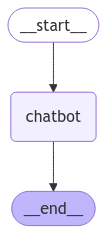

In [7]:
# Display the Graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
# Passing a input to test the Agent

user_input = "What do you know about AI?"
print("User: " + user_input)

for event in graph.stream({"messages": [("user", user_input)]}):
  for value in event.values():
    print("Assistant:", value["messages"][-1].content)

User: What do you know about AI?
Assistant: Artificial Intelligence (AI) refers to the simulation of human intelligence processes by machines, particularly computer systems. These processes include learning (the acquisition of information and rules for using it), reasoning (the use of rules to reach approximate or definite conclusions), and self-correction. Here are some key aspects of AI:

1. **Types of AI**:
   - **Narrow AI**: Designed to perform a specific task (e.g., virtual assistants, recommendation systems).
   - **General AI**: Hypothetical AI that possesses the ability to understand, learn, and apply intelligence across a wide range of tasks at a human level. This type of AI does not yet exist.

2. **Subfields of AI**:
   - **Machine Learning (ML)**: A subset of AI focused on building systems that learn from and make predictions or decisions based on data. It includes techniques such as supervised learning, unsupervised learning, and reinforcement learning.
   - **Natural Lan

## Adding tools to this Simple Agent

We will using Tavily search engine. Get tavily API key from https://tavily.com/

In [ ]:
!pip install tavily-python langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
os.environ['TAVILY_API_KEY'] = userdata.get('tavily')

In [ ]:
# tavily is available from langchain community library
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

# testing
tool.invoke("What is ML?")

[{'url': 'https://www.ibm.com/think/topics/machine-learning',
  'content': 'Machine learning (ML) is a branch of artificial intelligence (AI) and computer science that focuses on the using data and algorithms to enable AI to imitate the way that humans learn, gradually improving its accuracy. Supervised learning, also known as supervised machine learning, is defined by its use of labeled datasets to train algorithms to classify data or predict outcomes accurately. Reinforcement machine learning is a machine\xa0learning model that is similar to supervised learning, but the algorithm isn’t trained using sample data. However, implementing machine learning in businesses has also raised a number of ethical concerns about AI technologies. Train, validate, tune and deploy generative AI, foundation models and machine learning capabilities with IBM watsonx.ai, a next-generation enterprise studio for AI builders.'},
 {'url': 'https://www.geeksforgeeks.org/introduction-machine-learning/',
  'cont

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition

# ToolNode -> A node that runs the tools called in the last AIMessage.
# It can be used either in StateGraph with a "messages" state key (or a custom key passed via ToolNode's 'messages_key').
# If multiple tool calls are requested, they will be run in parallel.
# The output will be a list of ToolMessages, one for each tool call.
# tools_condition -> Use in the conditional_edge to route to the ToolNode if the last message has tool calls.
# Otherwise, route to the end.

In [ ]:
# New Agent

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

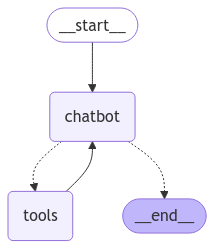

In [ ]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
# Passing a input to test the Agent with tool calling
user_input = "What do you know about AI?"
print("User: " + user_input)

for event in graph.stream({"messages": [("user", user_input)]}):
  for value in event.values():
    print("Assistant:", value["messages"][-1].content)

User: What do you know about AI?
Assistant: Artificial Intelligence (AI) refers to the simulation of human intelligence processes by machines, especially computer systems. These processes include learning (the acquisition of information and rules for using it), reasoning (using rules to reach approximate or definite conclusions), problem-solving, perception, language understanding, and more.

Here are some key points about AI:

1. **Types of AI**:
   - **Narrow AI**: Designed to perform a narrow task (e.g., facial recognition, internet searches).
   - **General AI**: Theoretical AI that has the ability to understand, learn, and apply intelligence to solve any problem, similar to human cognitive abilities.

2. **Machine Learning (ML)**: A subset of AI that involves training algorithms on data so that they can make predictions or decisions without being explicitly programmed.

3. **Deep Learning**: A further subset of ML that uses artificial neural networks to process vast amounts of dat

## Add memory to the Agent

As discussed earlier, memory can be very useful in maintaining the context for the LLM and provide relevant answers to next user queries.

LangGraph has persistent checkpointing. By providing a checkpointer during the graph compilation and specifying a thread_id when invoking the graph, LangGraph automatically saves the state after each step. When the graph is invoked again using the same thread_id, it loads the saved state, enabling the chatbot to resume from where it previously left off.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

Currently using an memory checkpointer. This is limited till experimentations but in a production application, you should switch to use SqliteSaver or PostgresSaver and connect to your own DB to store the chat memory of graph.

In [ ]:
# Building the Agent with Memory
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=memory)

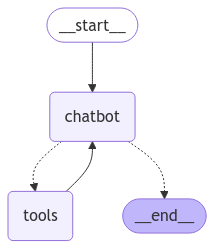

In [ ]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
config = {"configurable": {"thread_id": "User_1"}}

user_input = "Hi, my name is Chirag"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Chirag
================================== Ai Message ==================================

Hello Chirag! How can I assist you today?


In [ ]:
user_input = "Do you know my name?"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Do you know my name?
================================== Ai Message ==================================

Yes, you mentioned that your name is Chirag. How can I assist you further?


### What would happen if I change my config

In [ ]:
config = {"configurable": {"thread_id": "User_2"}}

user_input = "Do you know my name?"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Do you know my name?
================================== Ai Message ==================================

I don't have access to personal information about users unless you've shared it with me during our conversation. Therefore, I don't know your name. If you'd like me to know your name, feel free to share it!


As expected, as the thread id has changed, it doesn't have access to memory of other thread

## Snapshot of current state

In [ ]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Do you know my name?', additional_kwargs={}, response_metadata={}, id='f86f01b0-9314-4e80-8c18-88d2a4d99ca9'), AIMessage(content="I don't have access to personal information about users unless you've shared it with me during our conversation. Therefore, I don't know your name. If you'd like me to know your name, feel free to share it!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 85, 'total_tokens': 129, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-cf71db83-631e-4cfb-8fc8-343af1cd1d26-0', usage_metadata={'input_tokens': 85, 'output_tokens': 44, 'total_tokens': 129, 'input_to

## Multi LLM Agent Flow

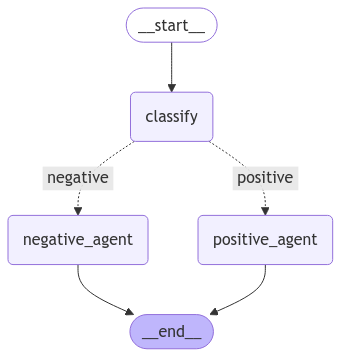

In [ ]:
from langchain.prompts import PromptTemplate

def classify_feedback(state):
    llm = ChatOpenAI()
    prompt = PromptTemplate.from_template("""
    You are a sentiment analysis agent. You need to classify the following feedback as either positive or negative.

    Feedback: {input}

    Your answer (positive/negative):
    """)
    chain = prompt | llm
    response = chain.invoke({"input": state["input"]})
    sentiment = response.content.strip().lower()
    return {"sentiment": sentiment, "input": state["input"]}

# Handling positive feedback with a thank-you message
def handle_positive_feedback(state):
    llm = ChatOpenAI()
    prompt = PromptTemplate.from_template(
        "Thank the customer for their positive feedback: {input}"
    )
    chain = prompt | llm
    response = chain.invoke({"input": state["input"]})
    return {"output": response}

# Handling negative feedback with an apology and improvement promise
def handle_negative_feedback(state):
    llm = ChatOpenAI()
    prompt = PromptTemplate.from_template(
        "Apologize to the customer and assure them that the issue will be addressed: {input}"
    )
    chain = prompt | llm
    response = chain.invoke({"input": state["input"]})
    return {"output": response}

# Defining the agent state
# Check how there is a change in the functions above where we have specifically used input, output and sentiment
class AgentState(TypedDict):
    input: str
    output: str
    sentiment: str

# Creating the workflow
workflow = StateGraph(AgentState)

workflow.add_node("classify", classify_feedback)
workflow.add_node("positive_agent", handle_positive_feedback)
workflow.add_node("negative_agent", handle_negative_feedback)

workflow.add_conditional_edges(
    "classify",
    lambda x: x["sentiment"],
    {
        "positive": "positive_agent",
        "negative": "negative_agent"
    }
)

workflow.set_entry_point("classify")
workflow.add_edge("positive_agent", END)
workflow.add_edge("negative_agent", END)
workflow.compile()

In [ ]:
def get_feedback(user_input):
  events = graph.stream(
      {"messages": [("user", user_input)]}, config, stream_mode="values"
  )

  for event in events:
      event["messages"][-1].pretty_print()

user_inputs = ["I absolutely loved the service! The staff were friendly, and everything went smoothly. I'll definitely come back!",
            "The service was slow, and the staff seemed disinterested. I had to wait much longer than expected.",
            "My experience was frustrating. The website was hard to navigate, and I couldn't find the information I needed."]

for input in user_inputs:
  get_feedback(input)
  print("\n")

================================ Human Message =================================

I absolutely loved the service! The staff were friendly, and everything went smoothly. I'll definitely come back!
================================== Ai Message ==================================

I'm glad to hear that you had a great experience! If you have any specific questions or if there's anything else you'd like to share about your experience, feel free to let me know. Looking forward to assisting you again!


================================ Human Message =================================

The service was slow, and the staff seemed disinterested. I had to wait much longer than expected.
================================== Ai Message ==================================

I'm sorry to hear that your experience was not satisfactory. Slow service and unengaged staff can be quite frustrating. If you plan to provide feedback to the establishment, it might be helpful to mention specific details about your ex